# Changes in aerobic habitat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cartopy
import cartopy.crs as ccrs
import cmocean
import data_collections as dc
import funnel
import intake
import matplotlib.pyplot as plt
import numpy as np
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='25GB')
    cluster.scale(6)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.15:46791,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=[m for m in dc.ocean_bgc_member_ids if m not in [17, 103]],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,30
variable,8
name,1
path,437


In [5]:
def fix_dataset(ds):
    ds['depth_habitat_trait_wgt'] = ds.depth_habitat_trait_wgt.where(ds.KMT > 0)
    return ds.set_coords(['TLAT', 'TLONG'])


cat = catalog.search(variable='depth_habitat_trait_wgt')
dsets = cat.to_dataset_dict(preprocess=fix_dataset, zarr_kwargs={'use_cftime': True})
dsets = {k: ds for k, ds in dsets.items()}


exp_keys = ['20C.ocn.pop.h.drift-corrected', 'RCP85.ocn.pop.h.drift-corrected']
ds = xr.concat([dsets[k] for k in exp_keys], dim='time', coords='minimal', compat='override')
ds['TLAT'] = ds.TLAT[0, :, :]
ds['TLONG'] = ds.TLONG[0, :, :]
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


<xarray.Dataset>
Dimensions:                  (nlat: 384, nlon: 320, member_id: 30, time: 2172, z_t: 40)
Coordinates:
    KMT                      (nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TAREA                    (nlat, nlon) float64 1.125e+13 ... 7.432e+12
    TLAT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                     (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
    ULONG                    (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
    dz                       (z_t) float32 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * time                     (time) object 1920-01-17 00:29:59.999993 ... 210...
  * z_t                      (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
  * member_id                (member_id) int64 2 9 10 11 12 ... 101 102 104 105
Dimensions without coordinates: nlat, nlon
Data variables:
    depth_habitat_trait_wgt  (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 12, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    nco_openmp_thread_number:  1
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    intake_esm_varname:        ['depth_habitat_trait_wgt']
    calendar:                  All years have exactly  365 days.
    nsteps_total:              750
    tavg_sum:                  2592000.0
    ...                        ...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    history:                   Tue Sep 10 06:07:07 2013: /glade/apps/opt/nco/...
    tavg_sum_qflux:            2592000.0
    source:                    CCSM POP2, the CCSM Ocean Component
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

In [6]:
ds.depth_habitat_trait_wgt

<xarray.DataArray 'depth_habitat_trait_wgt' (member_id: 30, time: 2172, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(30, 2172, 384, 320), dtype=float64, chunksize=(1, 12, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
  * time       (time) object 1920-01-17 00:29:59.999993 ... 2100-12-16 12:00:00
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 32 34 35 101 102 104 105
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Trait-space weighted vertical habitat
    note:          corrected for drift in control integration
    units:         centimeters eV 1/kPa

In [7]:
yrfrac = util.year_frac(ds.time)
tndx_ref = np.where(yrfrac < 1966)[0]
tndx_2100 = np.where(yrfrac > 2080)[0]

In [8]:
with xr.set_options(keep_attrs=True):
    aero_hab_glb = (ds.depth_habitat_trait_wgt * ds.TAREA).sum(['nlat', 'nlon']).compute()
    aero_hab_glb *= 1e-6 * 1e-6
    aero_hab_glb.attrs['units'] = '10$^6$ m$^3$'
    aero_hab_glb.attrs['long_name'] = 'Trait-space weighted aerobic habitat'

    aero_hab_glb_control = aero_hab_glb.isel(time=tndx_ref).mean(['time', 'member_id'])
    aero_hab_glb_normalized = (
        100.0 * (aero_hab_glb - aero_hab_glb_control) / aero_hab_glb_control
    ).compute()
    aero_hab_glb_normalized['units'] = '%'


aero_hab_glb

<xarray.DataArray (member_id: 30, time: 2172)>
array([[1.24686774e+11, 1.24671609e+11, 1.24593177e+11, ...,
        1.10375375e+11, 1.10216178e+11, 1.10023231e+11],
       [1.24690276e+11, 1.24667046e+11, 1.24554626e+11, ...,
        1.10238877e+11, 1.10069193e+11, 1.09901588e+11],
       [1.24691952e+11, 1.24638207e+11, 1.24577448e+11, ...,
        1.10154813e+11, 1.09978279e+11, 1.09827989e+11],
       ...,
       [1.24678380e+11, 1.24654564e+11, 1.24554592e+11, ...,
        1.09664746e+11, 1.09484113e+11, 1.09292341e+11],
       [1.24683358e+11, 1.24660820e+11, 1.24589422e+11, ...,
        1.10147047e+11, 1.09981233e+11, 1.09807093e+11],
       [1.24682364e+11, 1.24641171e+11, 1.24579969e+11, ...,
        1.10062213e+11, 1.09898004e+11, 1.09745475e+11]])
Coordinates:
  * time       (time) object 1920-01-17 00:29:59.999993 ... 2100-12-16 12:00:00
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 32 34 35 101 102 104 105
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Trait-space weighted aerobic habitat
    note:          corrected for drift in control integration
    units:         10$^6$ m$^3$

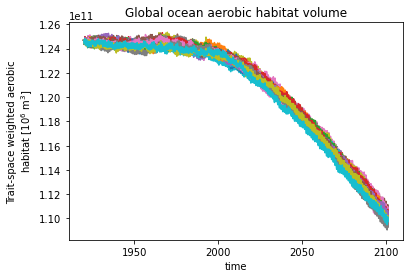

In [9]:
fig, ax = plt.subplots()

for member_id in aero_hab_glb.member_id.values:
    if (aero_hab_glb.sel(member_id=member_id)[-10:] == 0.0).all():
        print(member_id)
        continue
    aero_hab_glb.sel(member_id=member_id).plot(ax=ax)

ax.set_title('Global ocean aerobic habitat volume');

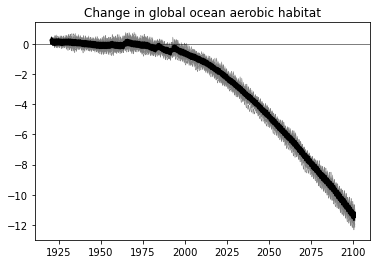

In [10]:
fig, ax = plt.subplots()

for member_id in aero_hab_glb.member_id.values:
    if (aero_hab_glb.sel(member_id=member_id)[-10:] == 0.0).all():
        print(member_id)
        continue
    ax.plot(
        yrfrac,
        aero_hab_glb_normalized.sel(member_id=member_id),
        linestyle='-',
        color='gray',
        linewidth=0.5,
    )

ax.plot(yrfrac, aero_hab_glb_normalized.mean('member_id'), '-', color='k', linewidth=2)
ax.axhline(0.0, linewidth=0.5, color='k')
ax.set_title('Change in global ocean aerobic habitat');

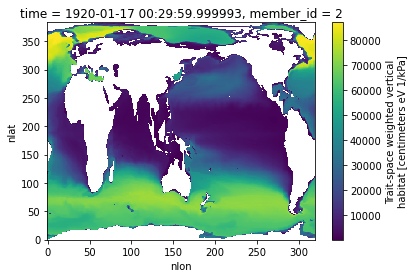

In [11]:
ds.depth_habitat_trait_wgt.isel(member_id=0, time=0).plot()

In [12]:
habitat_contraction = (
    ds.depth_habitat_trait_wgt.isel(time=tndx_2100).mean(['time', 'member_id'])
    - ds.depth_habitat_trait_wgt.isel(time=tndx_ref).mean(['time', 'member_id'])
).compute()
habitat_contraction /= 1000e2
habitat_contraction *= 100.0
habitat_contraction.attrs['long_name'] = 'Habitat change'
habitat_contraction.attrs['units'] = '%'
habitat_contraction.name = 'habitat_contraction'

habitat_contraction

<xarray.DataArray 'habitat_contraction' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.07114307, 0.07051179, 0.07067288, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Habitat change
    units:      %

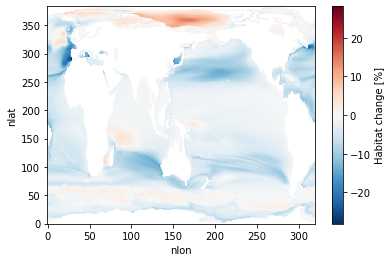

In [13]:
habitat_contraction.plot()

In [14]:
ds_plot = util.pop_add_cyclic(habitat_contraction.to_dataset())
ds_plot

<xarray.Dataset>
Dimensions:              (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                 (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                (nlat, nlon) float64 -220.6 -219.4 ... -39.57 -39.86
    habitat_contraction  (nlat, nlon) float64 nan nan nan nan ... nan nan nan

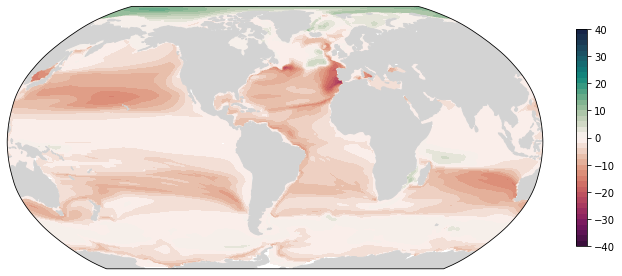

In [15]:
prj = ccrs.Robinson(central_longitude=305.0)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=prj))


cmap = cmocean.cm.curl_r

pc = ax.contourf(
    ds_plot.TLONG,
    ds_plot.TLAT,
    ds_plot.habitat_contraction,
    levels=np.arange(-40, 42, 2),
    cmap=cmap,
    transform=ccrs.PlateCarree(),
)

land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature(
        'physical', 'land', '110m', edgecolor='face', facecolor='lightgray'
    )
)
plt.colorbar(pc, shrink=0.5);